# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os

from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel
from cods.od.visualization import plot_preds

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # chose the GPU. If only one, then "0"

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = 0.5  # set 0.5 to use 50% for calibration and 50% for testing

use_smaller_subset = True

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio,
        shuffle=False,
        n_calib_test=800,
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
    filter_preds_by_confidence=4e-2,
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
    filter_preds_by_confidence=4e-2,
)

Predictions already exist, loading them...
Predictions already exist, loading them...


# New Tests

In [6]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="mix",
    multiple_testing_correction=None,
    confidence_method="box_count_recall",
    localization_method="pixelwise",
    localization_prediction_set="multiplicative",
    classification_method="binary",
    classification_prediction_set="lac",
)

[2025-08-19 02:33:15:WARNING:cp.py:cp:747 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-08-19 02:33:15:INFO:cp.py:cp:186 - __init__ ] Defaulting to CRC backend
[2025-08-19 02:33:15:INFO:cp.py:cp:511 - __init__ ] Defaulting to CRC backend


In [7]:
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.02,
    alpha_localization=0.05,
    alpha_classification=0.05,
)


[2025-08-19 02:33:15:INFO:cp.py:cp:965 - calibrate ] Calibrating Confidence Conformalizer
/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:501: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([Qs]).to(device)
[2025-08-19 02:33:16:INFO:optim.py:optim:195 - optimize ] First risk: 0.01702885702252388


[2025-08-19 02:33:18:INFO:optim.py:optim:418 - optimize ] Solution Found: 0.9259868562221527 with risk 0.02025293931365013


--------------------------------------------------
Lambdas
	previous_lbd = 0.9259868562221527
	Last Lambda = 0.9258964955806732
	Other previous lbd = 0.9259868562221527
	Other current lbd = 0.9258964955806732
All risks raw (precomputed):
	Confidence Risk: 0.019421683624386787
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019421683624386787
All risks monotonized (precomputed):
	Confidence Risk: 0.019421683624386787
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019421683624386787
Confidence risk (recomputed):
	Confidence Risk: 0.016970239579677582
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 241 loss: tensor([0.]) (eval) vs tensor([0.3333]) (opti)
	Image 241 confidence: tensor([0.9993, 0.9794, 0.0740])
	Image 241 number of ground truths: 3
	Image 241 number of predictions: 3
--------------------------------------------------


[2025-08-19 02:33:19:INFO:optim.py:optim:195 - optimize ] First risk: 0.014535090886056423
[2025-08-19 02:33:22:INFO:optim.py:optim:418 - optimize ] Solution Found: 0.8939756602048874 with risk 0.02033606544137001
[2025-08-19 02:33:22:INFO:cp.py:cp:975 - calibrate ] Setting Confidence Threshold of Predictions
[2025-08-19 02:33:22:INFO:cp.py:cp:987 - calibrate ] Calibrated Confidence λ : 0.9260
	 and associated Confidence Threshold : 0.07401314377784729
[2025-08-19 02:33:22:INFO:cp.py:cp:1002 - calibrate ] Matching Predictions to True Boxes


--------------------------------------------------
Lambdas
	previous_lbd = 0.8939756602048874
	Last Lambda = 0.893954761326313
	Other previous lbd = 0.8939756602048874
	Other current lbd = 0.893954761326313
All risks raw (precomputed):
	Confidence Risk: 0.019837310537695885
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019837310537695885
All risks monotonized (precomputed):
	Confidence Risk: 0.019837310537695885
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019837310537695885
Confidence risk (recomputed):
	Confidence Risk: 0.01988690346479416
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 321 loss: tensor([0.4000]) (eval) vs tensor([0.6000]) (opti)
	Image 321 confidence: tensor([0.9971, 0.9690, 0.1060])
	Image 321 number of ground truths: 5
	Image 321 number of predictions: 3
--------------------------------------------------


400it [00:00, 8054.89it/s]
[2025-08-19 02:33:22:INFO:cp.py:cp:1015 - calibrate ] Calibrating Localization Conformalizer
[2025-08-19 02:33:22:INFO:optim.py:optim:748 - optimize ] Using overload confidence threshold: 0.1060
[0.27, 0.29] -> λ=0.28076171875. Corrected Risk = 0.050: 100%|██████████| 13/13 [00:26<00:00,  2.02s/it]
[2025-08-19 02:33:48:INFO:cp.py:cp:270 - calibrate ] Calibrated λ for localization: 0.29296875
[2025-08-19 02:33:48:INFO:cp.py:cp:1025 - calibrate ] Calibrated Localization λ : 0.29296875
[2025-08-19 02:33:48:INFO:cp.py:cp:1033 - calibrate ] Calibrating Classification Conformalizer
[2025-08-19 02:33:48:WARNING:cp.py:cp:541 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[2025-08-19 02:33:48:INFO:optim.py:optim:748 - optimize ] Using overload confidence threshold: 0.1060
[1.00, 1.00] -> λ=0.9999963343143463. Corrected Risk = 0.0

In [8]:
conformal_preds = conf.conformalize(preds_val, parameters=parameters)

[2025-08-19 02:34:47:INFO:cp.py:cp:1085 - conformalize ] Conformalizing Predictions
[2025-08-19 02:34:47:INFO:cp.py:cp:1088 - conformalize ] Using provided parameters for conformalization
[2025-08-19 02:34:47:INFO:cp.py:cp:1094 - conformalize ] The parameters have been computed on another set of predictions.
[2025-08-19 02:34:47:INFO:cp.py:cp:1106 - conformalize ] Conformalizing Confidence
[2025-08-19 02:34:47:INFO:cp.py:cp:1125 - conformalize ] Conformalizing Localization
[2025-08-19 02:34:47:INFO:cp.py:cp:312 - conformalize ] Using previous λ for localization
[2025-08-19 02:34:47:INFO:cp.py:cp:327 - conformalize ] Conformalizing Localization with λ
[2025-08-19 02:34:47:INFO:cp.py:cp:1136 - conformalize ] Conformalizing Classification


In [9]:
results_val = conf.evaluate(
    preds_val,
    parameters=parameters,
    conformalized_predictions=conformal_preds,
    include_confidence_in_global=False,
)

Confidence threshold is 0.07401314377784729
Matching is : True
Matching complete
Confidence threshold: 0.07401314377784729
ODParameters
global_alpha: 0.12000000000000001
alpha_confidence: 0.02
alpha_localization: 0.05
alpha_classification: 0.05
lambda_confidence_plus: 0.9259868562221527
lambda_confidence_minus: 0.8939756602048874
lambda_localization: 0.29296875
lambda_classification: 0.9999963343143463
confidence_threshold: 0.07401314377784729


[2025-08-19 02:34:48:INFO:cp.py:cp:1197 - evaluate ] Evaluation Results:
[2025-08-19 02:34:48:INFO:cp.py:cp:1199 - evaluate ] 	 Confidence:
[2025-08-19 02:34:48:INFO:cp.py:cp:1200 - evaluate ] 		 Risk: 0.03
[2025-08-19 02:34:48:INFO:cp.py:cp:1201 - evaluate ] 		 Mean Set Size: 20.50
[2025-08-19 02:34:48:INFO:cp.py:cp:1205 - evaluate ] 	 Localization:
[2025-08-19 02:34:48:INFO:cp.py:cp:1206 - evaluate ] 		 Risk: 0.07
[2025-08-19 02:34:48:INFO:cp.py:cp:1207 - evaluate ] 		 Mean Set Size: 1.59
[2025-08-19 02:34:48:INFO:cp.py:cp:1211 - evaluate ] 	 Classification:
[2025-08-19 02:34:48:INFO:cp.py:cp:1212 - evaluate ] 		 Risk: 0.04
[2025-08-19 02:34:48:INFO:cp.py:cp:1213 - evaluate ] 		 Mean Set Size: 18.61
[2025-08-19 02:34:48:INFO:cp.py:cp:1217 - evaluate ] 	 Global:
[2025-08-19 02:34:48:INFO:cp.py:cp:1221 - evaluate ] 		 Risk: 0.09585651755332947


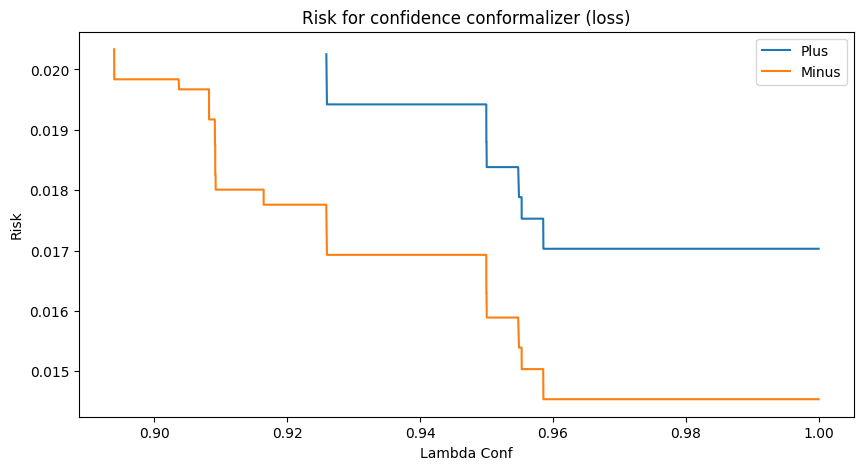

In [10]:
import matplotlib.pyplot as plt

# n = len(conf.classification_conformalizer.optimizer2.all_risks_mon)
# step = n // 25
# now plot each subpart of length step of the array
plt.figure(figsize=(10, 5))
# Fixed ticks:
# plt.xticks(
##    [i for i in range(0, n, step)],
#   [f"Step {i//step + 1}" for i in range(0, n, step)],
# )
# yticks between 0.04 and 0.14
# plt.yticks(
#    [i / 100 for i in range(4, 15)],
#    [f"{i / 100:.2f}" for i in range(4, 15)],
# )
# plt.ylim(0.04, 0.14)
plt.xlabel("Lambda Conf")
plt.ylabel("Risk")
plt.title("Risk for confidence conformalizer (loss)")
plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_mon,
    # label=f"Step {i//step + 1}",
    label="Plus",
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_mon,
    # label=f"Step {i//step + 1}",
    label="Minus",
)
# plt.plot(
#     conf.confidence_conformalizer.optimizer2_plus.all_lbds,
#     conf.confidence_conformalizer.optimizer2_plus.all_risks_raw,
#     # label=f"Step {i//step + 1}",
#     #label="Plus",
# )
# plt.plot(
#     conf.confidence_conformalizer.optimizer2_minus.all_lbds,
#     conf.confidence_conformalizer.optimizer2_minus.all_risks_raw,
#     # label=f"Step {i//step + 1}",
#     #label="Minus",
# )
plt.legend()

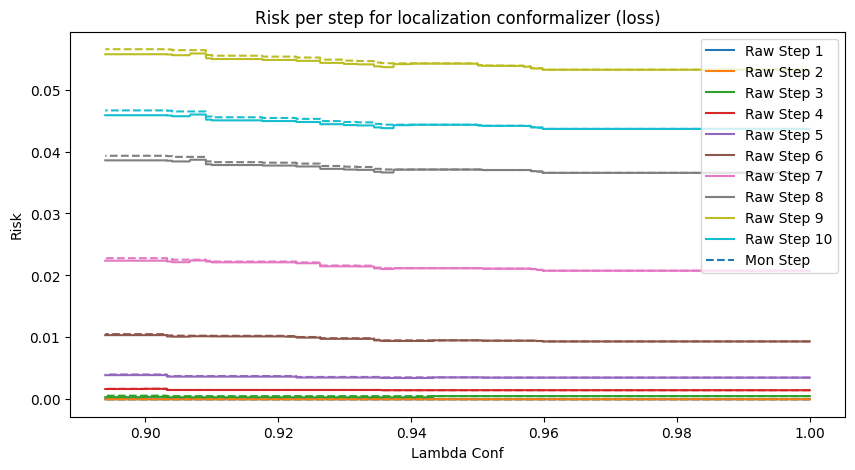

In [11]:
import matplotlib.pyplot as plt

n = 10
# now plot each subpart of length step of the array
plt.figure(figsize=(10, 5))
# Fixed ticks:
# plt.xticks(
#     [i for i in range(0, n, step)],
#     [f"Step {i//step + 1}" for i in range(0, n, step)],
# )
# # yticks between 0.04 and 0.14
# plt.yticks(
#     [i / 100 for i in range(4, 15)],
#     [f"{i / 100:.2f}" for i in range(4, 15)],
# )
# plt.ylim(0.03, 0.07)
plt.xlabel("Lambda Conf")
plt.ylabel("Risk")
plt.title("Risk per step for localization conformalizer (loss)")
colors = plt.cm.tab10.colors  # tuple of 10 distinct colors
color_map = {i: colors[i % len(colors)] for i in range(n)}
for i in range(0, n):
    plt.plot(
        conf.localization_conformalizer.optimizer2.all_lbds_cnf[i],
        conf.localization_conformalizer.optimizer2.all_risks_raw[i],
        label=f"Raw Step {i + 1}",
        c=color_map[i],
    )
for i in range(0, n):
    plt.plot(
        conf.localization_conformalizer.optimizer2.all_lbds_cnf[i],
        conf.localization_conformalizer.optimizer2.all_risks_mon[i],
        label=f"Mon Step" if i == 0 else None,
        c=color_map[i],
        linestyle="--",
    )
plt.legend()
# plt.plot(conf.localization_conformalizer.optimizer2.all_lbds_cnf, conf.localization_conformalizer.optimizer2.all_risks_mon)

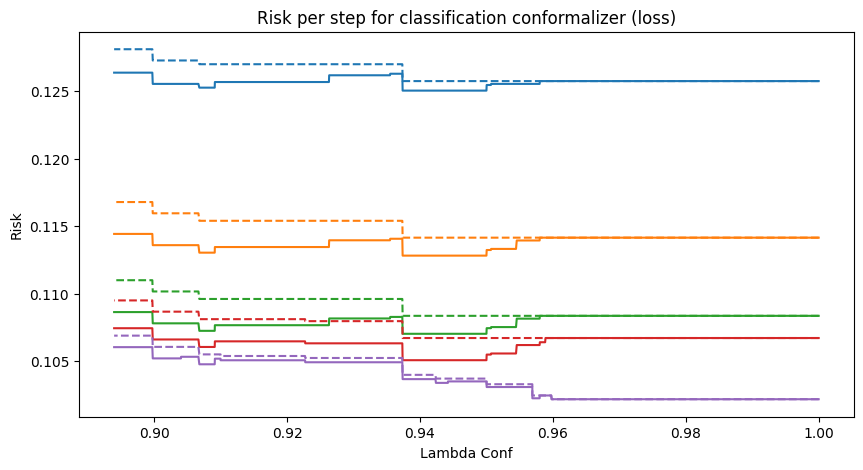

In [12]:
import matplotlib.pyplot as plt

n = 5  # 25
# now plot each subpart of length step of the array
plt.figure(figsize=(10, 5))
# Fixed ticks:
# plt.xticks(
#     [i for i in range(0, n, step)],
#     [f"Step {i//step + 1}" for i in range(0, n, step)],
# )
# yticks between 0.04 and 0.14
# plt.yticks(
#     [i / 100 for i in range(4, 15)],
#     [f"{i / 100:.2f}" for i in range(4, 15)],
# )
# plt.ylim(0.04, 0.14)
plt.xlabel("Lambda Conf")
plt.ylabel("Risk")
plt.title("Risk per step for classification conformalizer (loss)")
colors = plt.cm.tab10.colors  # tuple of 10 distinct colors
color_map = {i: colors[i % len(colors)] for i in range(n)}
for i in range(0, n):
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[i],
        conf.classification_conformalizer.optimizer2.all_risks_raw[i],
        label=f"Raw Step {i + 1}",
        c=color_map[i],
    )
for i in range(0, n):
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[i],
        conf.classification_conformalizer.optimizer2.all_risks_mon[i],
        label=f"Mon Step {i + 1}",
        linestyle="--",
        c=color_map[i],
    )
# plt.legend()
# plt.plot(conf.localization_conformalizer.optimizer2.all_lbds_cnf, conf.localization_conformalizer.optimizer2.all_risks_mon)

Using confidence threshold from preds


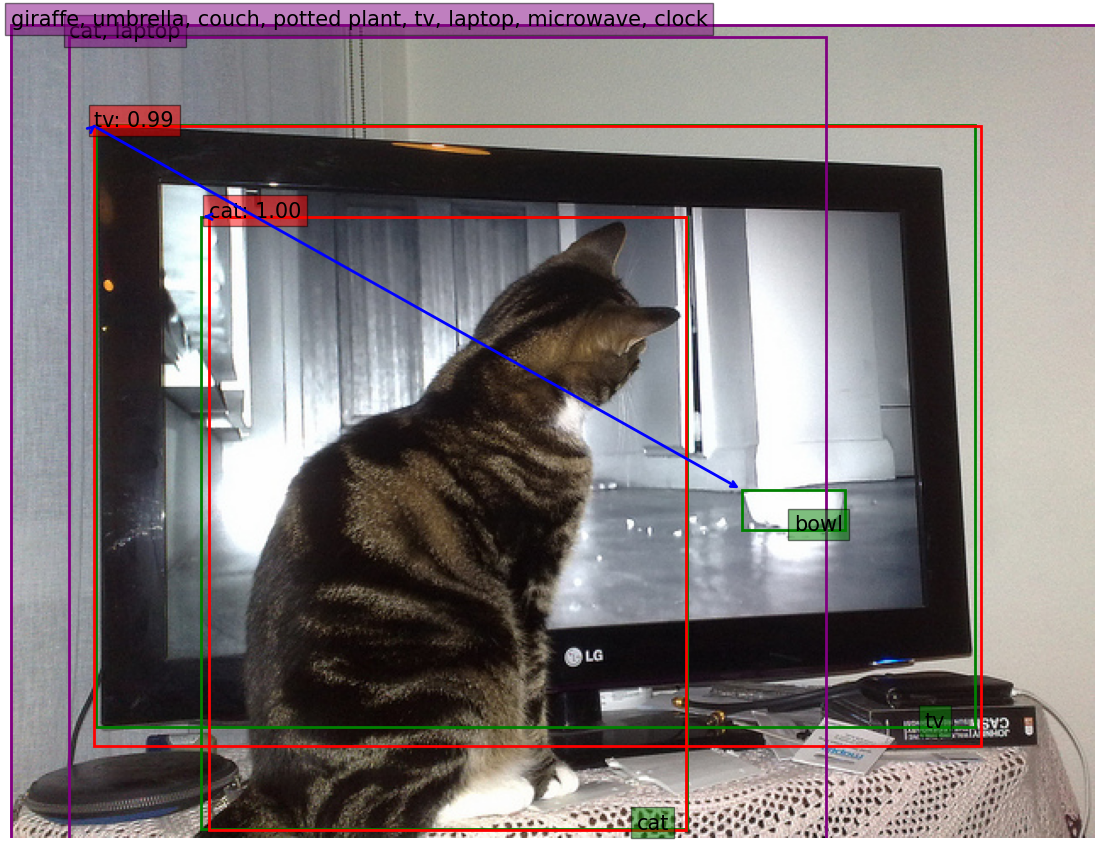

In [13]:
idx = 12
plot_preds(idx, preds_val, conformal_preds, idx_to_label=MSCOCODataset.NAMES)
